This project is to improve machine learning prediction accuracy by error shaping. 

Prediction uncertainty can be classified into epistemic uncertainty and aleatoric uncertainty which are reflected from model noise and predicton noise respectively. As the name suggested, epistemic uncertainty stems from the lack of knowledge, it can be reduced by learning from more data, it is also called reducible uncertainty. While aleatoric uncertainty comes from the intrinsic noise of data itself, it can not be reduced by collecting more data, it is also called irreducible uncertainty. 

For epistemic uncertainty, it has further two resources: the uncertainty of the model and the uncertainty of the parameters of a given model. 

According to 

#### The dataset is from UCI Machine Learning Repository, more description can be found [here](https://archive.ics.uci.edu/ml/datasets/Auto+MPG):


In [42]:
!pip install -q seaborn
from __future__ import absolute_import, division, print_function
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

1.14.0-rc1


'/root/.keras/datasets/auto-mpg.data'

In [43]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
print(dataset.groupby('Cylinders').nunique())
print(dataset.groupby('Origin').nunique())
dataset.tail()

           MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
Cylinders                                ...                                  
3            4          1             2  ...             2           4       1
4           87          1            44  ...            74          13       3
5            3          1             3  ...             3           3       1
6           38          1            18  ...            39          12       3
8           27          1            19  ...            35          11       1

[5 rows x 8 columns]
        MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
Origin                                ...                                  
1        82          3            48  ...            75          13       1
2        42          3            30  ...            43          13       1
3        54          3            25  ...            42          13       1

[3 rows x 8 columns]


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [44]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [45]:
dataset = dataset.dropna()
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


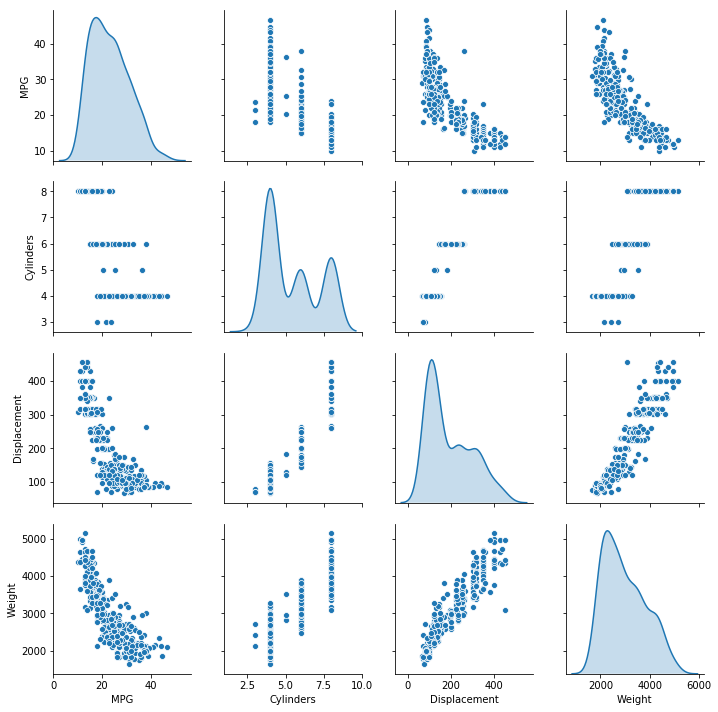

In [46]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [47]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = model.fit(
  normed_train_data, train_labels,
  epochs=1000, validation_split = 0.2, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,3.125917,1.139121,3.125917,8.692693,2.238054,8.692693,995
996,3.077332,1.146693,3.077332,8.791285,2.254010,8.791285,996
997,3.031233,1.098273,3.031233,8.104203,2.145322,8.104203,997
998,2.967662,1.090828,2.967662,8.940128,2.249222,8.940127,998
999,3.030888,1.125096,3.030888,8.515129,2.191306,8.515129,999


In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  y_max = max(hist['val_mean_absolute_error'])
  plt.ylim([0,y_max*1.2])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  y_max = max(hist['val_mean_squared_error'])
  plt.ylim([0,y_max*1.2])
  plt.legend()
  plt.show()

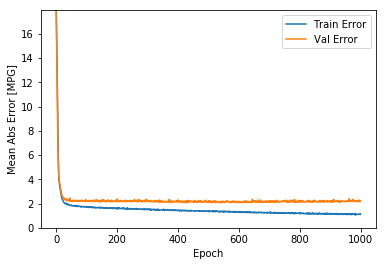

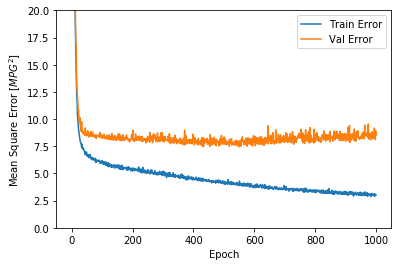

In [121]:
plot_history(history)

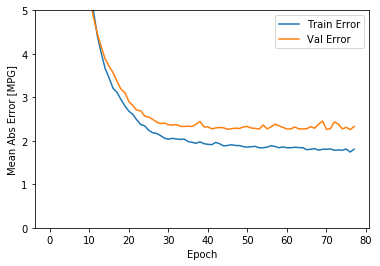

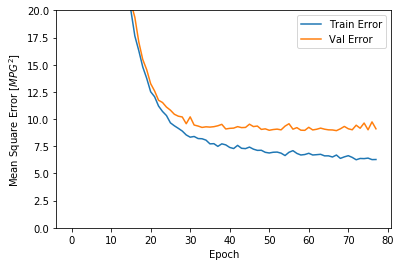

In [53]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

plot_history(history)

In [61]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

Testing set Mean Abs Error:  1.87 MPG


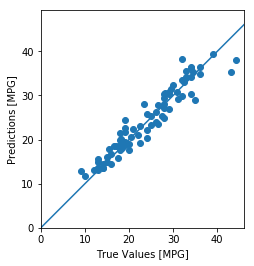

In [62]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

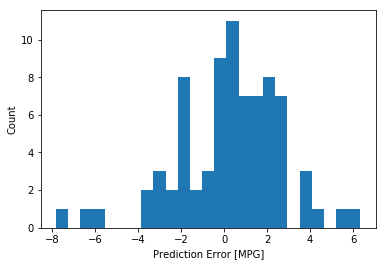

In [63]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [0]:
from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras import optimizers
from keras.callbacks import EarlyStopping, ProgbarLogger
import numpy as np

In [0]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [0]:
def custom_loss(hist):
#a, b are list of same length
  def KL(a, b):
      a = np.asarray(a, dtype=np.float)
      b = np.asarray(b, dtype=np.float)
      return np.sum(np.where(a != 0, a * np.log(a / b), 0))

  
  def normalKL(loss_hist_list):
    loss_hist_normal_list = np.random.normal(size=len(loss_hist_list))
    return KL(loss_hist_list, loss_hist_normal_list)

  loss_hist_list = hist.losses
  weight = 0.001
  
  def errorShape_loss(y_true, y_pred):
    mse = keras.losses.mean_squared_error(y_true, y_pred)
    distribution_loss = normalKL(loss_hist_list)
    return mse + weight*distribution_loss

  return errorShape_loss

In [140]:
def build_model_dist():
    
  #model = keras.Sequential([
  input = Input(shape=[len(train_dataset.keys())])
    #layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
  x = Dense(64, activation='relu', name="dense1")(input)   
    #layers.Dense(64, activation=tf.nn.relu),
  x = Dense(64, activation='relu', name="dense2")(x)
    #layers.Dense(1)
  output = Dense(1, activation='sigmoid', name='output')(x)
  #])
  model = Model(input=[input], output=[output])
  
  optimizer = optimizers.adam(lr=0.001, decay=1e-6)
  #optimizer = tf.keras.optimizers.RMSprop(0.001)

  #model.compile(loss='mean_squared_error',
  #model.compile(loss=custom_loss(model.get_layer('output')), 
  h = LossHistory()
  model.compile(loss=custom_loss(h), 
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model_dist = build_model_dist()
model_dist.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  if sys.path[0] == '':


AttributeError: ignored

In [134]:
def build_model_base():
    
  #model = keras.Sequential([
  input = Input(shape=[len(train_dataset.keys())])
    #layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
  x = Dense(64, activation='relu', name="dense1")(input)   
    #layers.Dense(64, activation=tf.nn.relu),
  x = Dense(64, activation='relu', name="dense2")(x)
    #layers.Dense(1)
  output = Dense(1, activation='sigmoid', name='output')(x)
  #])
  model = Model(input=[input], output=[output])
  
  optimizer = optimizers.adam(lr=0.001, decay=1e-6)
  #optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
  #model.compile(loss=custom_loss(model.get_layer('output')), 
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model_base = build_model_base()
model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 9)                 0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                640       
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  if sys.path[0] == '':


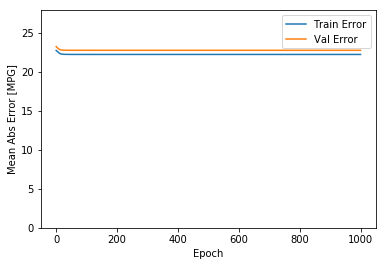

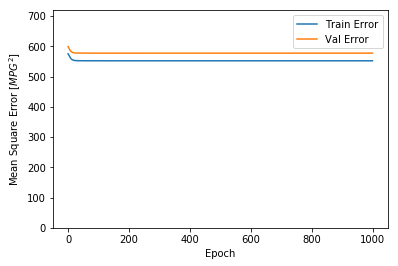

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  if sys.path[0] == '':


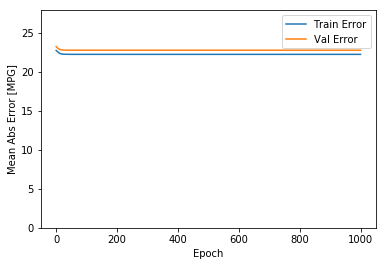

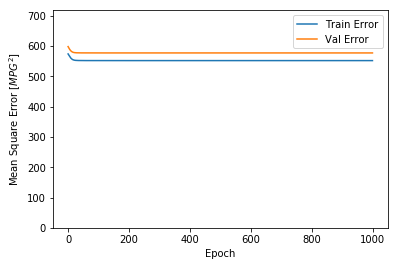

In [139]:
model_dist = build_model_dist()
his_dist = model_dist.fit(normed_train_data, train_labels,
          batch_size=128,
          validation_split = 0.2,
          epochs = 1000,
          verbose=0)
plot_history(his_dist)


model_base = build_model_base()
his_base = model_base.fit(normed_train_data, train_labels,
          batch_size=128,
          validation_split = 0.2,
          epochs = 1000,
          verbose=0)
plot_history(his_base)